## Import data

In [ ]:
import datasets
import pandas as pd

wikidata = datasets.load_dataset("wikipedia", "20220301.en", split=['train[:10%]'])
df_wiki = wikidata[0].to_pandas().sample(frac=1, random_state=42).reset_index(drop=True)[:100000]
df_wiki.head()

,Unnamed: 0,id,url,title,text
0,0,1658014,https://en.wikipedia.org/wiki/Adrienne%20Mayor,Adrienne Mayor,Adrienne Mayor (born 1946) is a historian of a...
1,1,415109,https://en.wikipedia.org/wiki/Jo%20Stafford,Jo Stafford,"Jo Elizabeth Stafford (November 12, 1917July 1..."
2,2,733308,https://en.wikipedia.org/wiki/Milan%20Rapai%C4%87,Milan Rapaić,"Milan ""Miki"" Rapaić (born 16 August 1973) is a..."
3,3,2597099,https://en.wikipedia.org/wiki/Windsor%20North%...,Windsor North School,Windsor North School is a primary school in In...
4,4,690250,https://en.wikipedia.org/wiki/List%20of%20rive...,List of rivers of Missouri,List of rivers in Missouri (U.S. state).\n\nBy...


In [ ]:
def count_len(sentence):
    return len(sentence.split())

df_wiki["document_length"] = df_wiki.text.map(count_len)

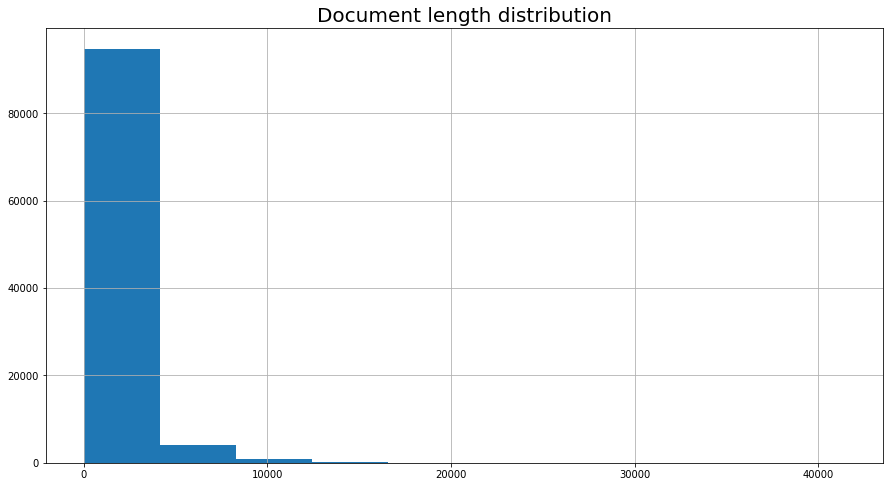

In [ ]:
df_wiki.hist("document_length", figsize=(15, 8))
plt.title("Document length distribution", fontsize=20)
plt.savefig("document_length")
plt.show()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import tensorflow as tf
from keras import backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Bidirectional, LSTM, Dropout
from keras.optimizers import RMSprop
import pickle
import heapq
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
if tf.test.gpu_device_name(): 
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
  print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


## Generate training data and prediction data

In [ ]:
def text_cleaner(text):
    clean_text = text.lower() # change to lower case
    # regex to match most of url links
    url = r'''(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}
    |www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}
    |www\.[a-zA-Z0-9]+\.[^\s]{2,})'''
    clean_text = re.sub(url, '', clean_text) # remove url links
    clean_text = re.sub(r'\([^)]*\)', '', clean_text) # remove text inside ()
    clean_text = re.sub(r'\[|\]', '', clean_text) # remove []
    clean_text = re.sub(r'\“|\”','', clean_text) # remove ""
    clean_text = re.sub(r'\"','', clean_text) # remove "
    clean_text = re.sub(r"(?<=\d),(?=\d)", "", clean_text) # remove , inside digit
    clean_text = re.sub(r"[\-\—]", " ", clean_text) # remove - and -- 
    clean_text = re.sub(r"\d+", "number", clean_text) # replace digit to number token
    clean_text = re.sub(r"'s", "", clean_text) # remove 's
    clean_text = re.sub(r"[^a-zA-Z0-9 \,\.\!\?]", "", clean_text) # remove text that are not english characters
    clean_text = re.sub(r"\s+", " ", clean_text) # remove extra white space
    return clean_text

In [ ]:
set_of_chars = sorted([' ', '!', ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'])
char_to_index = dict((c, i) for i, c in enumerate(set_of_chars))
index_to_char = dict((i, c) for i, c in enumerate(set_of_chars))
len(set_of_chars)

31

In [ ]:
def generator(data, document_size, sequence_length, step, batch_size=128):
    """python generator to create training documents."""
    for i in range(0, len(data), document_size):
        documents = data[i : i + batch_size]["text"].map(text_cleaner).tolist()
        sentences = []
        next_chars = []
        for text in documents:
            for i in range(0, len(text) - sequence_length, step):
                # generate fixed length sequence as training documents
                sentences.append(text[i: i + sequence_length])
                # use the next character as prediction documents
                next_chars.append(text[i + sequence_length])
        for i in range(0, len(sentences), batch_size):
            # generate batch
            current_sentence = sentences[i : i + batch_size]
            current_next_chars = next_chars[i : i + batch_size]
            # perform one-hot encoding
            X = np.zeros((batch_size, sequence_length, len(set_of_chars)), dtype=bool)
            y = np.zeros((batch_size, len(set_of_chars)), dtype=bool)
            for i, sentence in enumerate(current_sentence):
                for t, char in enumerate(sentence):
                    X[i, t, char_to_index[char]] = 1
            y[i, char_to_index[current_next_chars[i]]] = 1
            yield X, y

In [ ]:
def plot_history(history,title):
    """plot training and validation history"""
    loss = history['loss']
    val_loss = history['val_loss']
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']
    epochs = range(1, len(loss) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(epochs, loss, 'bo', label="Training")
    ax[0].plot(epochs, val_loss, 'b', label='Validation')
    ax[0].set_title("Training and validation loss")
    ax[1].plot(epochs, accuracy, 'bo')
    ax[1].plot(epochs, val_accuracy, 'b')
    ax[1].set_title("Training and validation accuracy")
    fig.suptitle('Training and validation loss and accuracy of ' + title, fontsize=15)
    fig.legend()
    fig.savefig('history_'+"_".join(title.split())+'.png')
    fig.show()

In [ ]:
N = len(df_wiki)
B1 = 0
B2 = int(N * 0.8)
B3 = B2
B4 = int(N * 0.9)
B5 = B4
B6 = int(N * 1.0)
EPOCHS = 10
f_batch = 1 / EPOCHS
batch_size = 128
batch_size_v = 128
steps_per_epoch  = 2500
val_steps = int(steps_per_epoch * 0.1)
sequence_length = 32
step = 4
document_size = 100

In [ ]:
# generate training, validation and test data
train_gen = generator(df_wiki[:B2], document_size, sequence_length=sequence_length, step=step)
val_gen = generator(df_wiki[B3:B4], document_size, sequence_length=sequence_length, step=step)
test_gen = generator(df_wiki[B5:B6], document_size, sequence_length=sequence_length, step=step)

## Model Training

### One layer of LSTM

In [ ]:
backend.clear_session()
model_lstm1 = Sequential()
model_lstm1.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars))))
model_lstm1.add(Dense(len(set_of_chars)))
model_lstm1.add(Activation('softmax'))
model_lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               81920     
                                                                 
 dense (Dense)               (None, 31)                3999      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 85,919
Trainable params: 85,919
Non-trainable params: 0
_________________________________________________________________


In [ ]:
EPOCHS = 10
steps_per_epoch = 2500
optimizer = RMSprop(learning_rate=0.01)
model_lstm1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_lstm1 = model_lstm1.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 25s 9ms/step - loss: 1.8747 - accuracy: 0.4529 - val_loss: 1.9694 - val_accuracy: 0.4192
Epoch 2/10
2500/2500 [==============================] - 19s 8ms/step - loss: 1.6148 - accuracy: 0.5267 - val_loss: 1.7635 - val_accuracy: 0.4833
Epoch 3/10
2500/2500 [==============================] - 22s 9ms/step - loss: 1.6143 - accuracy: 0.5247 - val_loss: 1.6919 - val_accuracy: 0.5028
Epoch 4/10
2500/2500 [==============================] - 22s 9ms/step - loss: 1.5503 - accuracy: 0.5409 - val_loss: 1.7622 - val_accuracy: 0.4929
Epoch 5/10
2500/2500 [==============================] - 21s 8ms/step - loss: 1.5821 - accuracy: 0.5346 - val_loss: 1.7380 - val_accuracy: 0.4959
Epoch 6/10
2500/2500 [==============================] - 19s 7ms/step - loss: 1.5495 - accuracy: 0.5447 - val_loss: 1.8113 - val_accuracy: 0.4804
Epoch 7/10
2500/2500 [==============================] - 23s 9ms/step - loss: 1.5490 - accuracy: 0.5417 - val_loss: 1.7071 - val_ac

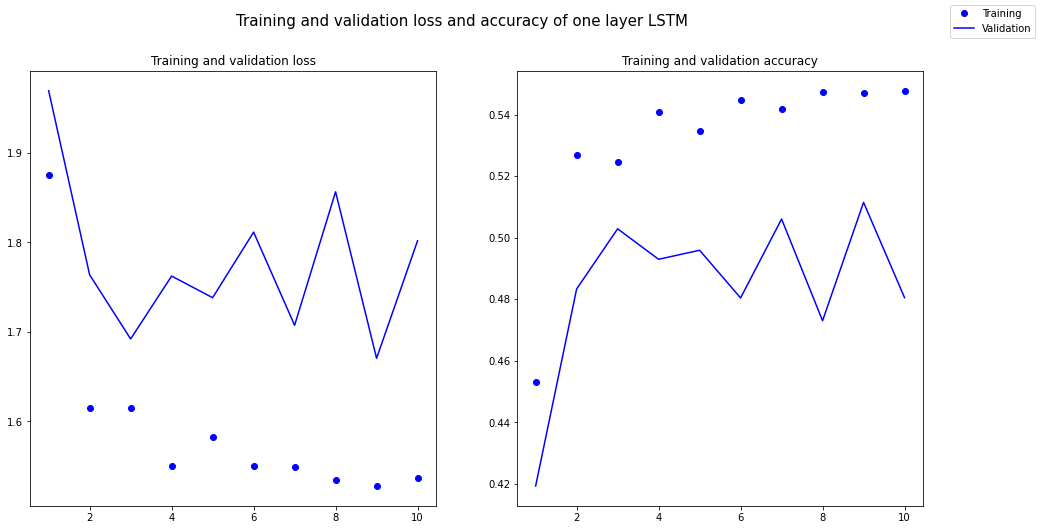

In [ ]:
plot_history(history_lstm1, "one layer LSTM")

### Tree layers of LSTM

In [ ]:
backend.clear_session()
model_lstm3 = Sequential()
model_lstm3.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm3.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm3.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars))))
model_lstm3.add(Dense(len(set_of_chars)))
model_lstm3.add(Activation('softmax'))
model_lstm3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 31)                3999      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 349,087
Trainable params: 349,087
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = RMSprop(learning_rate=0.001)
model_lstm3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_lstm3 = model_lstm3.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 40s 14ms/step - loss: 2.2877 - accuracy: 0.3286 - val_loss: 2.0302 - val_accuracy: 0.3995
Epoch 2/10
2500/2500 [==============================] - 34s 14ms/step - loss: 1.8487 - accuracy: 0.4530 - val_loss: 1.8660 - val_accuracy: 0.4511
Epoch 3/10
2500/2500 [==============================] - 34s 13ms/step - loss: 1.7162 - accuracy: 0.4947 - val_loss: 1.7917 - val_accuracy: 0.4703
Epoch 4/10
2500/2500 [==============================] - 34s 14ms/step - loss: 1.6296 - accuracy: 0.5225 - val_loss: 1.6732 - val_accuracy: 0.5048
Epoch 5/10
2500/2500 [==============================] - 34s 14ms/step - loss: 1.5969 - accuracy: 0.5325 - val_loss: 1.6869 - val_accuracy: 0.5049
Epoch 6/10
2500/2500 [==============================] - 34s 14ms/step - loss: 1.5441 - accuracy: 0.5482 - val_loss: 1.6755 - val_accuracy: 0.5124
Epoch 7/10
2500/2500 [==============================] - 34s 14ms/step - loss: 1.5479 - accuracy: 0.5433 - val_loss: 1.6878 -

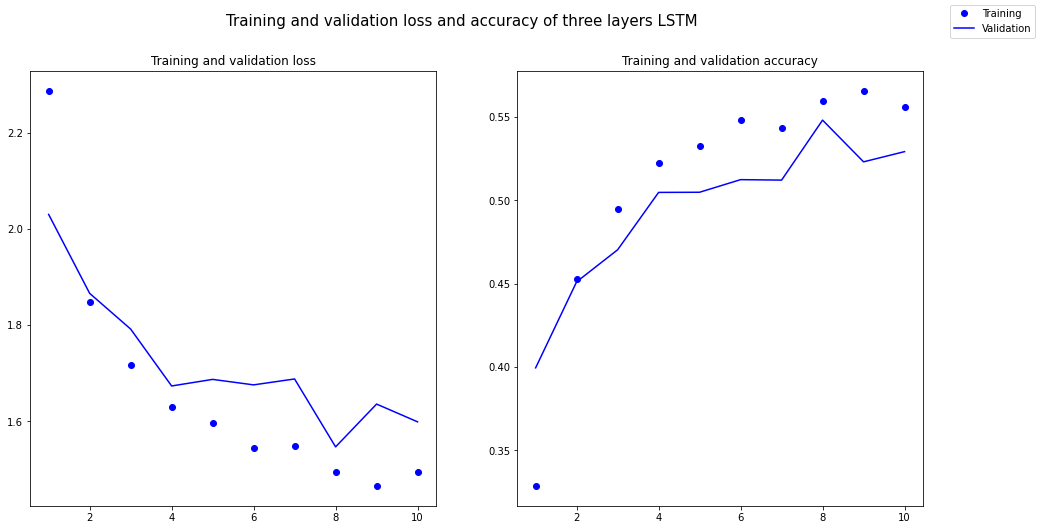

In [ ]:
plot_history(history_lstm3, "three layers LSTM")

### Five layers of LSTM

In [ ]:
backend.clear_session()
model_lstm5 = Sequential()
model_lstm5.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm5.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm5.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm5.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_lstm5.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars))))
model_lstm5.add(Dense(len(set_of_chars)))
model_lstm5.add(Activation('softmax'))
model_lstm5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           81920     
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           131584    
                                                                 
 lstm_2 (LSTM)               (None, 32, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 32, 128)           131584    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 31)                3999      
                                                                 
 activation (Activation)     (None, 31)                0

In [ ]:
optimizer = RMSprop(learning_rate=0.001)
model_lstm5.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_lstm5 = model_lstm5.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 110s 20ms/step - loss: 2.5138 - accuracy: 0.2681 - val_loss: 2.2081 - val_accuracy: 0.3499
Epoch 2/10
2500/2500 [==============================] - 49s 20ms/step - loss: 2.0086 - accuracy: 0.4064 - val_loss: 2.0871 - val_accuracy: 0.3810
Epoch 3/10
2500/2500 [==============================] - 50s 20ms/step - loss: 1.8423 - accuracy: 0.4568 - val_loss: 1.9258 - val_accuracy: 0.4368
Epoch 4/10
2500/2500 [==============================] - 52s 21ms/step - loss: 1.7333 - accuracy: 0.4888 - val_loss: 1.8440 - val_accuracy: 0.4574
Epoch 5/10
2500/2500 [==============================] - 49s 19ms/step - loss: 1.6683 - accuracy: 0.5098 - val_loss: 1.8246 - val_accuracy: 0.4667
Epoch 6/10
2500/2500 [==============================] - 49s 20ms/step - loss: 1.6186 - accuracy: 0.5226 - val_loss: 1.7110 - val_accuracy: 0.4934
Epoch 7/10
2500/2500 [==============================] - 50s 20ms/step - loss: 1.5938 - accuracy: 0.5326 - val_loss: 1.6346 

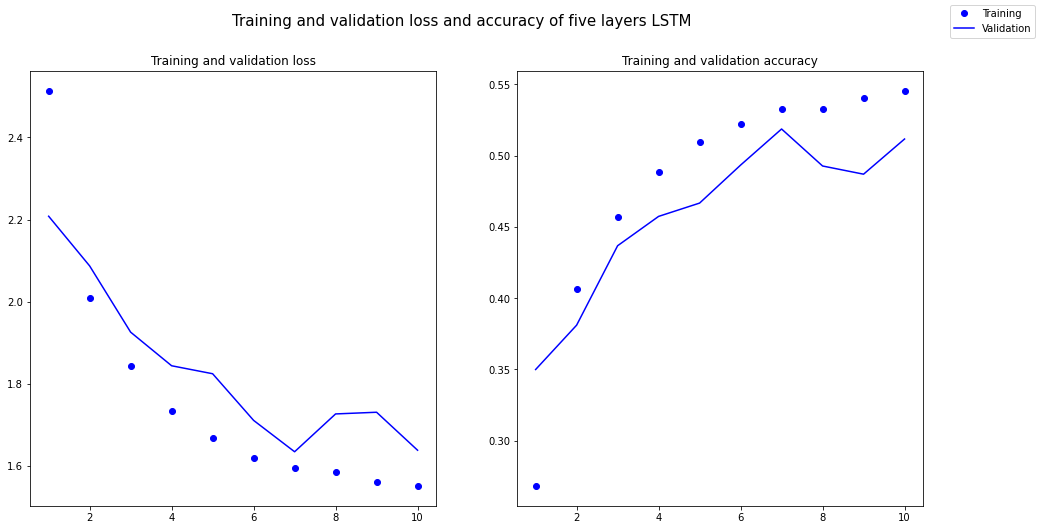

In [ ]:
plot_history(history_lstm5, "five layers LSTM")

### One layer of Bidirectional LSTM

In [ ]:
backend.clear_session() 
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(128), input_shape=(sequence_length, len(set_of_chars))))
model_bi.add(Dense(len(set_of_chars)))
model_bi.add(Activation('softmax'))
model_bi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              163840    
 l)                                                              
                                                                 
 dense (Dense)               (None, 31)                7967      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 171,807
Trainable params: 171,807
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = RMSprop(learning_rate=0.01)
model_bi.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_bi = model_bi.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 31s 11ms/step - loss: 1.8568 - accuracy: 0.4556 - val_loss: 1.8358 - val_accuracy: 0.4645
Epoch 2/10
2500/2500 [==============================] - 27s 11ms/step - loss: 1.6013 - accuracy: 0.5294 - val_loss: 1.7739 - val_accuracy: 0.4767
Epoch 3/10
2500/2500 [==============================] - 27s 11ms/step - loss: 1.6387 - accuracy: 0.5204 - val_loss: 1.9027 - val_accuracy: 0.4423
Epoch 4/10
2500/2500 [==============================] - 27s 11ms/step - loss: 1.6188 - accuracy: 0.5259 - val_loss: 1.6876 - val_accuracy: 0.4998
Epoch 5/10
2500/2500 [==============================] - 28s 11ms/step - loss: 1.5769 - accuracy: 0.5374 - val_loss: 1.6773 - val_accuracy: 0.5137
Epoch 6/10
2500/2500 [==============================] - 26s 10ms/step - loss: 1.5538 - accuracy: 0.5421 - val_loss: 1.6835 - val_accuracy: 0.5085
Epoch 7/10
2500/2500 [==============================] - 29s 11ms/step - loss: 1.5366 - accuracy: 0.5489 - val_loss: 1.6576 -

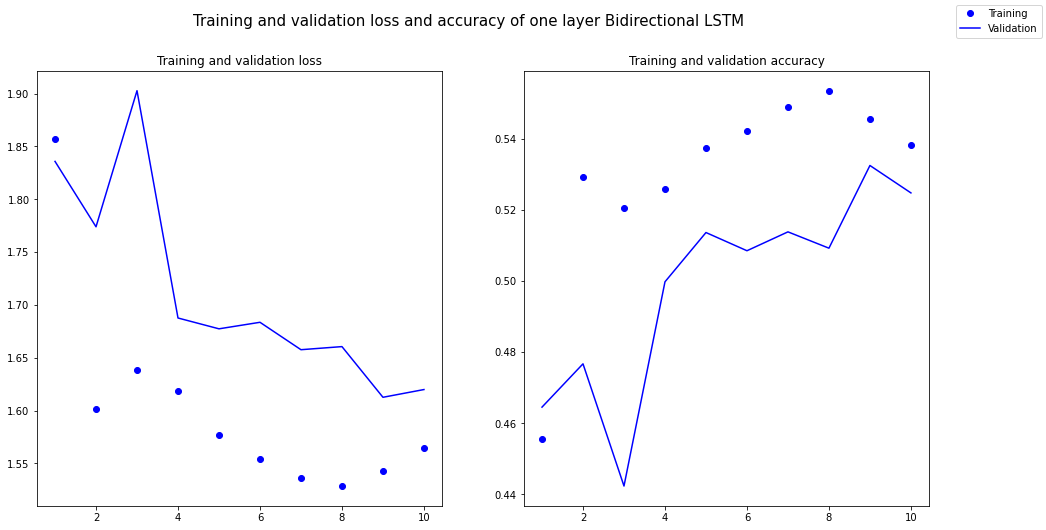

In [ ]:
plot_history(history_bi, "one layer Bidirectional LSTM")

### Two layers of Bidirectional LSTM

In [ ]:
backend.clear_session() 
model_bi2 = Sequential()
model_bi2.add(Bidirectional(LSTM(128,return_sequences=True), input_shape=(sequence_length, len(set_of_chars))))
model_bi2.add(Bidirectional(LSTM(128)))
model_bi2.add(Dense(len(set_of_chars)))
model_bi2.add(Activation('softmax'))
model_bi2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 32, 256)          163840    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 31)                7967      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 566,047
Trainable params: 566,047
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = RMSprop(learning_rate=0.001)
model_bi2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_bi2 = model_bi2.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 56s 20ms/step - loss: 2.1752 - accuracy: 0.3596 - val_loss: 2.0284 - val_accuracy: 0.3979
Epoch 2/10
2500/2500 [==============================] - 59s 24ms/step - loss: 1.8676 - accuracy: 0.4468 - val_loss: 1.9637 - val_accuracy: 0.4235
Epoch 3/10
2500/2500 [==============================] - 46s 18ms/step - loss: 1.7399 - accuracy: 0.4846 - val_loss: 1.8728 - val_accuracy: 0.4477
Epoch 4/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.6238 - accuracy: 0.5210 - val_loss: 1.7729 - val_accuracy: 0.4836
Epoch 5/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.5990 - accuracy: 0.5311 - val_loss: 1.7728 - val_accuracy: 0.4804
Epoch 6/10
2500/2500 [==============================] - 46s 18ms/step - loss: 1.5509 - accuracy: 0.5425 - val_loss: 1.7337 - val_accuracy: 0.4969
Epoch 7/10
2500/2500 [==============================] - 45s 18ms/step - loss: 1.5340 - accuracy: 0.5484 - val_loss: 1.7549 -

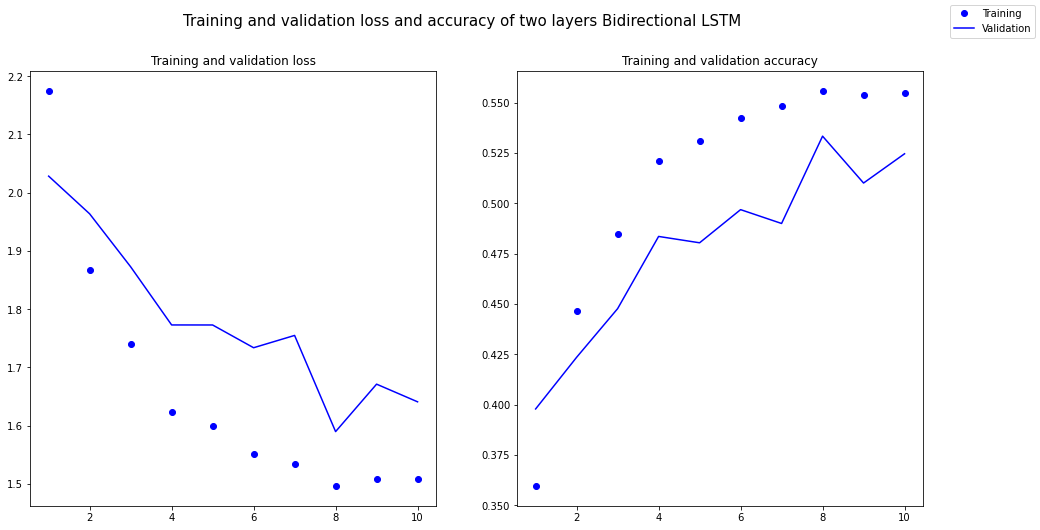

In [ ]:
plot_history(history_bi2, "two layers Bidirectional LSTM")

### One layer of LSTM and one layer of bidirectional LSTM

In [ ]:
backend.clear_session() 
model_bi3 = Sequential()
model_bi3.add(LSTM(128, input_shape=(sequence_length, len(set_of_chars)), return_sequences=True))
model_bi3.add(Bidirectional(LSTM(128), input_shape=(sequence_length, len(set_of_chars))))
model_bi3.add(Dense(len(set_of_chars)))
model_bi3.add(Activation('softmax'))
model_bi3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 128)           81920     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense (Dense)               (None, 31)                7967      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 353,055
Trainable params: 353,055
Non-trainable params: 0
_________________________________________________________________


In [ ]:
optimizer = RMSprop(learning_rate=0.001)
model_bi3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history_bi3 = model_bi3.fit(train_gen, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, validation_data=val_gen, validation_steps=val_steps).history

Epoch 1/10
2500/2500 [==============================] - 73s 15ms/step - loss: 2.2513 - accuracy: 0.3389 - val_loss: 2.0183 - val_accuracy: 0.4048
Epoch 2/10
2500/2500 [==============================] - 37s 15ms/step - loss: 1.8980 - accuracy: 0.4366 - val_loss: 1.8845 - val_accuracy: 0.4420
Epoch 3/10
2500/2500 [==============================] - 42s 17ms/step - loss: 1.7967 - accuracy: 0.4724 - val_loss: 1.8457 - val_accuracy: 0.4526
Epoch 4/10
2500/2500 [==============================] - 35s 14ms/step - loss: 1.6963 - accuracy: 0.5011 - val_loss: 1.8339 - val_accuracy: 0.4586
Epoch 5/10
2500/2500 [==============================] - 36s 14ms/step - loss: 1.6438 - accuracy: 0.5199 - val_loss: 1.7599 - val_accuracy: 0.4835
Epoch 6/10
2500/2500 [==============================] - 36s 14ms/step - loss: 1.5720 - accuracy: 0.5371 - val_loss: 1.7425 - val_accuracy: 0.4922
Epoch 7/10
2500/2500 [==============================] - 38s 15ms/step - loss: 1.5435 - accuracy: 0.5449 - val_loss: 1.7247 -

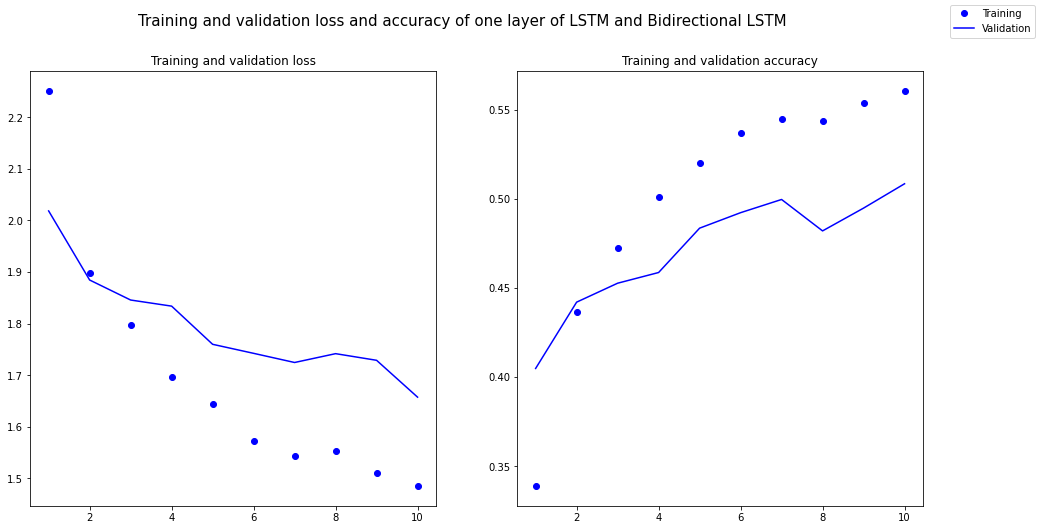

In [ ]:
plot_history(history_bi3, "one layer of LSTM and Bidirectional LSTM")

## Model Evaluation

In [ ]:
model_lstm1.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 12s 5ms/step - loss: 1.6879 - accuracy: 0.5039


[1.6878947019577026, 0.5039250254631042]

In [ ]:
model_lstm3.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 18s 7ms/step - loss: 1.5888 - accuracy: 0.5271


[1.5888339281082153, 0.5270718932151794]

In [ ]:
model_lstm5.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 24s 10ms/step - loss: 1.6678 - accuracy: 0.5123


[1.6677533388137817, 0.5123000144958496]

In [ ]:
model_bi.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 15s 6ms/step - loss: 1.7027 - accuracy: 0.5058


[1.7027207612991333, 0.5058281421661377]

In [ ]:
model_bi2.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 21s 8ms/step - loss: 1.6551 - accuracy: 0.5161


[1.6550683975219727, 0.5161406397819519]

In [ ]:
model_bi3.evaluate(test_gen, steps=2500)

2500/2500 [==============================] - 18s 7ms/step - loss: 1.6590 - accuracy: 0.5163


[1.6589900255203247, 0.516281247138977]

Choose model using three layers of LSTM

In [ ]:
# save model
model_lstm3.save('autocomplete_model.h5')
pickle.dump(history_lstm3, open("history.p", "wb"))

## Load model

In [ ]:
import numpy as np
import re
from keras.models import load_model
import pickle

In [2]:
model = load_model('autocomplete_model.h5')
history = pickle.load(open("history.p", "rb"))

## Build autocomplete function using model

In [3]:
class Autocomplete:
    def __init__(self, model, set_of_chars, sequence_length, char_to_index, index_to_char):
        self.model = model
        self.set_of_chars = set_of_chars
        self.set_length = len(set_of_chars)
        self.sequence_length = sequence_length
        self.char_to_index = char_to_index
        self.index_to_char = index_to_char

    def encode_input(self, text):
        """Perform one-hot encoding to input sentence"""
        encoded_text = np.zeros((1, self.sequence_length, self.set_length))
        for t, char in enumerate(text):
            encoded_text[0, t, self.char_to_index[char]] = 1    
        return encoded_text

    def top_prediction(self, preds, n):
        """Get top n predictions"""
        preds = np.array(preds)
        # softmax
        preds = np.log(preds)
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds)
        return np.argsort(preds)[:len(preds)-n-1:-1]

    def predict_word(self, text):
        """Make prediction"""
        original_text = text
        completion = ''
        # continue making prediction until hit white space
        while True:
            x = self.encode_input(text) # encode input sentence
            preds = self.model.predict(x, verbose=0)[0] # prediction
            next_index = self.top_prediction(preds, n=1)[0] # the most likely next character
            next_char = self.index_to_char[next_index]
            text = text[1:] + next_char # add prediction to text and move one position
            completion += next_char
            # check if prediction is white space or prediction begins to repeat or completion length is more than 15
            if (next_char == ' ') or (completion[-1:] == completion[-2:-1]) or (len(completion) > 15):
                return completion
  
    def predict_words_n(self, text, n):
        encoded_text = self.encode_input(text)
        preds = self.model.predict(encoded_text, verbose=0)[0]
        next_indices = self.top_prediction(preds, n) # top n predictions
        # iterate every character in top n predictions
        return [self.index_to_char[index] + self.predict_word(text[1:] + self.index_to_char[index]) for index in next_indices]

    def autocomplete(self, sentence, n=3):
        """autocomplete function"""
        # if the input sentence doesn't have enough characters
        if len(sentence) < self.sequence_length:
            print(sentence)
            print(f"Please provde at least {self.sequence_length} characters")
        else:
            seq = sentence[len(sentence)-self.sequence_length:]
            predictions = self.predict_words_n(seq.lower(), n)
            print(sentence)
            print(predictions)
            return predictions

# Test autocomplete function

In [4]:
set_of_chars = [' ', '!', ',', '.', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j',
  'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
char_to_index = dict((c, i) for i, c in enumerate(set_of_chars))
index_to_char = dict((i, c) for i, c in enumerate(set_of_chars))
sequence_length = 32
word_completion = Autocomplete(model, set_of_chars, sequence_length, char_to_index, index_to_char)

In [5]:
sentence_example = ["This is an incomplete example se", 
           "Sensitivity refers to the probab", 
           "Natural language processing is a subfield of linguistics, computer sci", 
           "Mayor specializes in ancient history",
           "Since number, mayor has been a research",
           "Sentence is a set of words that is comp",
           "Machine learning is a field of inquiry devoted to und"]

for sentence in sentence_example:
    word_completion.autocomplete(sentence, 5)

This is an incomplete example se
['rved ', 'cret ', 'en ', 'ason ', 't ']
Sensitivity refers to the probab
['ly ', ' and ', 'ily ', 'e ', 'ory ']
Natural language processing is a subfield of linguistics, computer sci
['ence ', 'le ', 'te ', 'nce ', 're ']
Mayor specializes in ancient history
[' of ', ', ', '. ', 'ing ', 's ']
Since number, mayor has been a research
[' and ', 'er ', ', ', 'ing ', '. ']
Sentence is a set of words that is comp
['any ', 'leted ', 'eted ', 'osed ', 'rised ']
Machine learning is a field of inquiry devoted to und
['er ', 'ive ', 'ar ', 'ourgh ', 'ust ']
